# Example of Graph Neural Network

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

sys.path.append('../..')
device = "cuda" if torch.cuda.is_available() else "cpu"

## Attention Mechanism

In [2]:
from LightningModules.GNN.Models.vanilla_checkagnn import VanillaCheckResAGNN
from LightningModules.GNN.Models.test_checkagnn import TestCheckResAGNN
from LightningModules.GNN.Models.checkpoint_pyramid import CheckpointedPyramid

In [3]:
with open("example_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
torch.manual_seed(0)
model = CheckpointedPyramid(hparams)

### Dataset

In [84]:
%%time
model.setup(stage="fit")

CPU times: user 17 ms, sys: 65.4 ms, total: 82.4 ms
Wall time: 81.9 ms


In [ ]:
sample = model.trainset[0]

In [15]:
sample

Data(edge_index=[2, 1222586], event_file="PileUp40_10K_withTruth/event000000000", hid=[20233], layerless_true_edges=[2, 18161], layers=[20233], pid=[20233], signal_true_edges=[2, 18161], x=[20233, 3], y=[1222586], y_pid=[1222586])

In [16]:
sample.y.sum()/sample.signal_true_edges.shape[1]

tensor(0.9707)

In [17]:
sample.y.sum()/sample.edge_index.shape[1]

tensor(0.0144)

In [18]:
edges = sample.edge_index

In [19]:
pid = sample.pid

In [20]:
edges.shape

torch.Size([2, 1222586])

In [21]:
(sample.pid[edges[0]] == sample.pid[edges[1]]).sum()/sample.edge_index.shape[1]

tensor(0.0282)

### Memory Test

In [6]:
optimizer, _ = model.configure_optimizers()
optimizer = optimizer[0]

In [7]:
%%time
model.setup(stage="fit")

CPU times: user 23.8 ms, sys: 77.2 ms, total: 101 ms
Wall time: 159 ms


In [8]:
sample = model.trainset[0].to(device)

In [9]:
model = model.to(device)

In [15]:
torch.cuda.reset_peak_memory_stats()
optimizer.zero_grad()
output = model(sample.x.to(device), sample.edge_index.to(device))

In [16]:
output.sum().backward()

In [17]:
optimizer.step()

Checkpoint pyramid

In [18]:
output

tensor([[-1.0907],
        [-1.0904],
        [-1.0908],
        ...,
        [-0.9562],
        [-0.9549],
        [-0.9549]], device='cuda:0', grad_fn=<CheckpointFunctionBackward>)

In [19]:
print(torch.cuda.max_memory_allocated()/1024**3, "Gb")

6.731334686279297 Gb


Checkpoint

In [92]:
output

tensor([[-0.3758],
        [-0.3769],
        [-0.3763],
        ...,
        [-0.1346],
        [-0.1299],
        [-0.1298]], device='cuda:0', grad_fn=<CheckpointFunctionBackward>)

In [93]:
print(torch.cuda.max_memory_allocated()/1024**3, "Gb")

9.04183292388916 Gb


In [80]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0045,  0.0437, -0.0644,  ...,  0.0341,  0.0623,  0.0444],
         [-0.0559, -0.0018, -0.0459,  ..., -0.0135,  0.0268,  0.0693],
         [ 0.0189,  0.0671,  0.0424,  ..., -0.0429, -0.0104,  0.0647],
         ...,
         [ 0.0511, -0.0354, -0.0066,  ...,  0.0257,  0.0288,  0.0486],
         [ 0.0653,  0.0051,  0.0374,  ..., -0.0119,  0.0226, -0.0603],
         [-0.0246, -0.0385, -0.0505,  ..., -0.0304, -0.0642, -0.0370]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0165, -0.0398, -0.0234, -0.0457, -0.0083,  0.0695,  0.0255,  0.0490,
         -0.0522, -0.0296,  0.0278, -0.0119,  0.0611, -0.0559, -0.0642, -0.0508,
         -0.0311,  0.0457, -0.0302, -0.0404, -0.0078,  0.0450, -0.0767, -0.0216,
         -0.0216, -0.0514, -0.0169, -0.0018, -0.0692,  0.0515,  0.0281,  0.0076,
          0.0047,  0.0067,  0.0616,  0.0090, -0.0025,  0.0032, -0.0540, -0.0661,
         -0.0088, -0.0703,  0.0348, -0.0454,  0.0042,  0.0254,

No Checkpoint

In [13]:
output

tensor([[-0.0456],
        [-0.0458],
        [-0.0455],
        ...,
        [ 0.2978],
        [ 0.3069],
        [ 0.3272]], device='cuda:0', grad_fn=<AddmmBackward>)

In [14]:
print(torch.cuda.max_memory_allocated()/1024**3, "Gb")

10.658188343048096 Gb


In [15]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0043,  0.0424, -0.0777,  ..., -0.0474, -0.0271, -0.0381],
         [-0.0259, -0.0674, -0.0238,  ..., -0.0208, -0.0475, -0.0377],
         [-0.0926,  0.0349, -0.0374,  ..., -0.0276,  0.0439,  0.0837],
         ...,
         [ 0.0074,  0.0807, -0.0504,  ..., -0.0560,  0.0766,  0.0577],
         [-0.0004,  0.0785, -0.0395,  ...,  0.0234,  0.0151,  0.0284],
         [ 0.0428, -0.0498,  0.0781,  ...,  0.0462,  0.0297,  0.0083]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0079,  0.0342,  0.0175, -0.0507, -0.0224, -0.0630,  0.0261,  0.0613,
         -0.0557,  0.0246, -0.0732,  0.0314, -0.0879, -0.0297, -0.0060, -0.0100,
          0.0547, -0.0402,  0.0243,  0.0338,  0.0192, -0.0806, -0.0440, -0.0167,
          0.0035,  0.0289,  0.0672,  0.0132, -0.0555, -0.0928,  0.0742,  0.0053,
         -0.0735, -0.0293,  0.0289, -0.0078,  0.0633, -0.0201,  0.0161,  0.0778,
         -0.0835,  0.0138, -0.0769, -0.0546, -0.0778,  0.0384,

### LR Tuning

In [6]:
trainer = Trainer(gpus=1, auto_lr_find=True)
# trainer.tune(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name          | Type       | Params
---------------------------------------------
0 | edge_network  | Sequential | 17.0 K
1 | node_network  | Sequential | 16.6 K
2 | input_network | Sequential | 4.7 K 
---------------------------------------------
38.3 K    Trainable params
0         Non-trainable params
38.3 K    Total params
0.153     Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'auc': 0.583066999912262,
 'current_lr': 0.00012022643932141364,
 'eff': 0.7650876045227051,
 'pur': 0.03465810790657997,
 'val_loss': 0.7197118401527405}
--------------------------------------------------------------------------------


/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'auc': 0.3491974174976349,
 'current_lr': 1.202264428138733,
 'eff': 0.0,
 'pur': nan,
 'val_loss': 0.3451094329357147}
--------------------------------------------------------------------------------


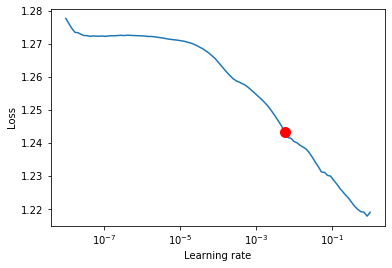

In [7]:
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

### Train GNN

In [ ]:
logger = WandbLogger(project="LRT_mu40_0GeV_GNN", group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=logger, precision=16)
trainer.fit(model)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 5.2 K 
1 | edge_network | Sequential | 6.3 K 
2 | node_network | Sequential | 12.0 K
--------------------------------------------
23.4 K    Trainable params
0         Non-trainable params
23.4 K    Total params
0.094     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradi

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients wil

Full precision

In [8]:
print(torch.cuda.max_memory_allocated()/1024**3, "Gb")

3.756938934326172 Gb


Mixed precision

In [7]:
print(torch.cuda.max_memory_allocated()/1024**3, "Gb")

12.815165519714355 Gb


## Load Model

In [10]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/itk_lightning_checkpoints/ITk_0.5GeV_GNN/k53btbvu/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

model = CheckpointedResAGNN.load_from_checkpoint(checkpoint_path).to(device)

In [11]:
model.eval();

In [16]:
model.hparams["datatype_split"] = [200, 1, 10]
model.setup(stage="fit")

In [17]:
model = model.to(device)

In [18]:
output_dir = "/project/projectdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_testing"

In [19]:
with torch.no_grad():
    for batch in model.train_dataloader():

        print(batch)

        output = model.shared_evaluation(batch.to(device), 0, log=False)

        print(output)
        print(os.path.split(batch.event_file[0])[-1])

        gnn_results = np.vstack([batch.edge_index.cpu().numpy(), 
                                 output["score"].cpu().numpy(), 
                                 output["truth"].cpu().numpy()])
        
        gnn_recarray = np.rec.fromarrays(gnn_results, names=["senders", "receivers", "score", "truth"])

        with open(os.path.join(output_dir, os.path.split(batch.event_file[0])[-1][-4:] + ".npz"), 'wb') as f:
            np.save(f, gnn_recarray)

Batch(batch=[63740], cell_data=[63740, 11], edge_index=[2, 402137], event_file=[1], hid=[63740], modulewise_true_edges=[2, 56793], nhits=[63740], pid=[63740], primary=[63740], pt=[63740], ptr=[2], signal_true_edges=[2, 56502], x=[63740, 3], y=[402137], y_pid=[402137])
{'loss': tensor(0.0642, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0'), 'score': tensor([0.0012, 0.0045, 0.0318,  ..., 0.9993, 0.9995, 0.9917], device='cuda:0'), 'truth': tensor([0., 0., 0.,  ..., 1., 1., 1.], device='cuda:0')}
event000000001
Batch(batch=[52517], cell_data=[52517, 11], edge_index=[2, 281245], event_file=[1], hid=[52517], modulewise_true_edges=[2, 46735], nhits=[52517], pid=[52517], primary=[52517], pt=[52517], ptr=[2], signal_true_edges=[2, 46497], x=[52517, 3], y=[281245], y_pid=[281245])
{'loss': tensor(0.0597, device='cuda:0'), 'preds': tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0'), 'score': tensor([6.2125e-07, 5.4918e-06